# A simple quantum circuit simulation


Create a quantum circuit with 3 qubits and 3 classical bits:

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3, 3)
# measure qubits 0, 1 & 2 to classical bits 0, 1 & 2, respectively
qc.measure([0,1,2], [0,1,2])
qc.draw()

┌─┐      
q_0: ┤M├──────
     └╥┘┌─┐   
q_1: ─╫─┤M├───
      ║ └╥┘┌─┐
q_2: ─╫──╫─┤M├
      ║  ║ └╥┘
c: 3/═╩══╩══╩═
      0  1  2

The quantum circuit includes the definition of the measurement and the storing of the measurement results in the classical bits.

Import Qiskit's simulator Aer and create new simulator object:

In [2]:
# pip install qiskit-aer
from qiskit_aer import AerSimulator
sim = AerSimulator()  # make new simulator object

Run the simulation:

In [3]:
job = sim.run(qc)      # run the experiment
result = job.result()  # get the results
result.get_counts()    # interpret the results as a "counts" dictionary

{'000': 1024}

Key is a bit string, and value is the number of times this bit string was measured. Since qubits are always initialized with 0,
and we do nothing to them, we will always get '000'.

Add X gates to some of the qubits, an X gate corresponds to a classical NOT gate:

In [4]:
qc = QuantumCircuit(4, 4)
qc.x([1])  # Perform X-gates on specified qubits
qc.measure([0,1,2,3], [0,1,2,3])
qc.draw()

┌─┐      
q_0: ─────┤M├──────
     ┌───┐└╥┘   ┌─┐
q_1: ┤ X ├─╫────┤M├
     └┬─┬┘ ║    └╥┘
q_2: ─┤M├──╫─────╫─
      └╥┘  ║ ┌─┐ ║ 
q_3: ──╫───╫─┤M├─╫─
       ║   ║ └╥┘ ║ 
c: 4/══╩═══╩══╩══╩═
       2   0  3  1

In [5]:
job = sim.run(qc)
result = job.result()
result.get_counts()

{'0010': 1024}

Note that the results in the bit string are positioned from right (0) to left.

# Half and full adder

Start with the half adder first:

In [6]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2, 2)
# Encode an input
qc.x(0)
qc.x(1)

# Apply "XOR" operation on qubits 0 and 1
qc.cx(0,1)  # CNOT controlled by qubit 0 and targeting qubit 1
qc.measure([0,1], [0,1])
display(qc.draw())

job = sim.run(qc)
result = job.result()
print("Result: ", result.get_counts())

┌───┐     ┌─┐   
q_0: ┤ X ├──■──┤M├───
     ├───┤┌─┴─┐└╥┘┌─┐
q_1: ┤ X ├┤ X ├─╫─┤M├
     └───┘└───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

Result:  {'01': 1024}


The cx method applied to qc will overwrite qubit 1 with the result of the half-addition.

0+0 = 0, 1+0 = 0+1 = 1, 1+1 = 0

Full adder:

In [7]:
qc = QuantumCircuit(4, 2)

# Encode an input
qc.x(0)
qc.x(1)

# Carry out the adder circuit
qc.cx(0,2) # input 0 => output (qubit 2) 0, input 1 => output 1 (target flipped if control is 1)
qc.cx(1,2) # input 0 => qubit 2 remains unchanged (result of first computation), input 1 => qubit 2 flipped (again)
# At this point qubit 2 holds the result of the half-addition of qubits 0 and 1.

# Add a second gate to calculate the carryover:
qc.ccx(0,1,3)

# Measure two qubits 2 and 3 to extract the output
qc.measure(2,0)
qc.measure(3,1)
qc.draw()

┌───┐                     
q_0: ┤ X ├──■─────────■────────
     ├───┤  │         │        
q_1: ┤ X ├──┼────■────■────────
     └───┘┌─┴─┐┌─┴─┐  │  ┌─┐   
q_2: ─────┤ X ├┤ X ├──┼──┤M├───
          └───┘└───┘┌─┴─┐└╥┘┌─┐
q_3: ───────────────┤ X ├─╫─┤M├
                    └───┘ ║ └╥┘
c: 2/═════════════════════╩══╩═
                          0  1

In [11]:
job = sim.run(qc)
result = job.result()
print("Result: ", result.get_counts())

Result:  {'10': 1024}


ccx is the CCNOT or <b>Toffoli</b> gate: target qubit inverted only if both control qubits are 1.

In all examples so far the quantum circuits corresponded to classical circuits. Now we look at the real quantum stuff.

# Quantum gates and state vectors

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

qc = QuantumCircuit(2)

# This calculates what the state vector of our qubits would be
# after passing through the circuit 'qc'
ket = Statevector(qc)

# Write down the state vector
ket.draw()

'Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],\n            dims=(2, 2))'

The state vector is the list of amplitudes of |00>, |01>, |10> and |11>. A state vector for a QC with $n$ qubits has $2^n$ components (complex amplitudes). Note that the Qiskit convention is to order qubits from right to left, i.e. |01> = (0,1,0,0) means that qubit 0 is in 1 state (|1>) and qubit 1 is in 0 state (|0>).

Now let Hadamard transformation work on qubit 1:

In [9]:
qc.h(1)

ket = Statevector(qc)
ket.draw()

'Statevector([0.70710678+0.j, 0.        +0.j, 0.70710678+0.j,\n             0.        +0.j],\n            dims=(2, 2))'

ket is now a superposition of |00> and |10>. We let the CNOT gate (cx) act on QC, with qubit 1 being the control (which is a superposition now) and qubit 0 the target qubit:

In [10]:
qc.cx(1,0)

ket = Statevector(qc)
ket.draw()

'Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,\n             0.70710678+0.j],\n            dims=(2, 2))'

This is an entangled state, i.e. it is not a product of two single qubits with two amplitudes: $$\frac{1}{\sqrt{2}} |00\rangle+\frac{1}{\sqrt{2}} |11\rangle$$

Disentangling can be done by applying the same operations in reverse order:

In [11]:
qc.cx(1,0)
qc.h(1)

ket = Statevector(qc)
ket.draw()

'Statevector([ 1.00000000e+00+0.j,  0.00000000e+00+0.j, -2.23711432e-17+0.j,\n              0.00000000e+00+0.j],\n            dims=(2, 2))'

# Simple message transmission using entangled state

Alice can encode a two-bit message by manipulating only one qubit in an entangled state: apply an X (NOT) or Z (phase flip) gate on that qubit depending on the message bits. Qubit 0 could be already transferred even before the message is known!

In [13]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

MESSAGE = '00'

qc = QuantumCircuit(2,2)

# Create an entangled pair (Bell state)
qc.h(1)
qc.cx(1,0)

# Encode the message -> Alice
if MESSAGE[0]=='1':
    qc.z(1)
if MESSAGE[1]=='1':
    qc.x(1)

# Disentangle the state
qc.cx(1,0)
qc.h(1)

# and measure -> Bob
qc.measure([0,1],[0,1])

qc.draw()

┌───┐┌───┐     ┌─┐   
q_0: ─────┤ X ├┤ X ├─────┤M├───
     ┌───┐└─┬─┘└─┬─┘┌───┐└╥┘┌─┐
q_1: ┤ H ├──■────■──┤ H ├─╫─┤M├
     └───┘          └───┘ ║ └╥┘
c: 2/═════════════════════╩══╩═
                          0  1

Note that the quantum circuits including its gates depend on the message contents. (How will that work in practice?)

In [14]:
result = AerSimulator().run(qc).result().get_counts()
print("Result: ", result)

Result:  {'00': 1024}


Measurements are used to get information out of qubits. Different properties of the qubits can be determined by applying different measurements.

The pure state of a single qubit corresponds to a point on the Bloch sphere.

A z measurement, the standard measurement, measures the qubit orientation with respect to the z axis, hence it returns 0 for a |0> ("north pole" of the Bloch sphere) and 1 for a |1> qubit ("south pole"). The x measurement does the same with respect to the x axis: rotate the qubit and apply a standard measurement.

# Measurements and rotations

In [15]:
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from math import pi

def do_measurement(qc):
    m_z = QuantumCircuit(1,1)
    m_z.measure(0,0)

    m_x = QuantumCircuit(1,1)
    m_x.h(0)
    m_x.measure(0,0)

    for axis_label, axis_m in [('z',m_z),('x',m_x)]:
        result = AerSimulator().run(qc.compose(axis_m)).result().get_counts()
        print("Result of " + axis_label + ' measurement: ', result)

# qubit initialized with default properties is a |0>
qc = QuantumCircuit(1,1)

do_measurement(qc)

# Phase flip and Hadamard = rotation by pi around x + z bisecting line
# Thus we feed a |-> into the measurement
qc.x(0)
qc.h(0)

do_measurement(qc)

# Rotate back
qc.h(0)
qc.x(0)

# and rotate by some angle around y axis
qc.ry(pi/4,0)

do_measurement(qc)

Result of z measurement:  {'0': 1024}
Result of x measurement:  {'0': 504, '1': 520}
Result of z measurement:  {'0': 476, '1': 548}
Result of x measurement:  {'1': 1024}
Result of z measurement:  {'1': 140, '0': 884}
Result of x measurement:  {'1': 132, '0': 892}


<b>Heisenberg uncertainty principle</b>: you cannot measure these two properties with certainty at the same time.

The compose method combines two quantum circuits by connecting ("wiring") them one after another.

<b>A measurement destroys a superposition.</b> If we apply a measurement to a superposition of |00> and |11>, with some probability we will measure either 00 or 11. After a measurement of 00 the quantum system will definitely be in state |00> (collapsed), similarly for 11 and |11>. Hence a second measurement will always yield the same result as the first one. We will never get 0011 or 1100.

In [16]:
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator

qc = QuantumCircuit(2,4)
qc.h(1)
qc.cx(1,0)

qc.measure([0,1],[0,1]) # measure QC and record result in classical bits 0 and 1
qc.measure([0,1],[2,3]) # measure the same QC again and record in bits 2 and 3

result = AerSimulator().run(qc,shots=100).result().get_counts()
print(result)

{'1111': 53, '0000': 47}


# A logical paradox

This is a variation of [Hardy's paradox](https://en.wikipedia.org/wiki/Hardy%27s_paradox). Suppose we create an entangled state and send each of the two qubits to different observers (Alice and Bob). Both apply a z measurement:

Results for z measurements:


Matplotlib is building the font cache; this may take a moment.


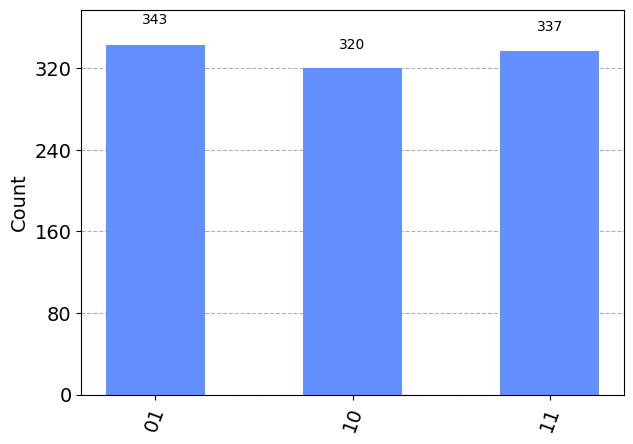

In [17]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import QasmSimulator
# pip install 'qiskit[visualization]'
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(2,2)
qc.ry(1.911,1)
qc.cx(1,0)
qc.ry(0.785,0)
qc.cx(1,0)
qc.ry(2.356,0)

m_zz = QuantumCircuit(2,2)
m_zz.measure([0,1],[0,1])

# Our "backend" is the simulator
backend = QasmSimulator()

# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
#
# We need to feed qc.compose into here because the compose method does
# not change qc to the composed circuit! I.e. this:
# qc.compose(m_zz)
# qc_compiled = transpile(qc,backend)
# leads to "no counts for experiment" error due to missing measurements.
qc_compiled = transpile(qc.compose(m_zz), backend)

# Execute the circuit on the qasm simulator
print('Results for z measurements:')
counts = backend.run(qc_compiled, shots=1000).result().get_counts(qc_compiled)
plot_histogram(counts)

In this case, the result 00 is never observed. Now let's look at what happens when one of the observers performs a z and the other an x measurement:

Results for z and x measurement:


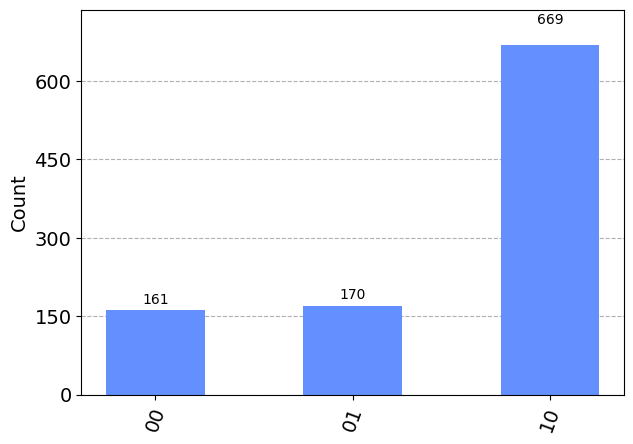

In [18]:
m_zx = QuantumCircuit(2,2)
m_zx.h(0)
m_zx.measure([0,1],[0,1])

qc_compiled = transpile(qc.compose(m_zx), backend)

print('Results for z and x measurement:')
counts = backend.run(qc_compiled, shots=1000).result().get_counts(qc_compiled)
plot_histogram(counts)

Results for x and z measurement:


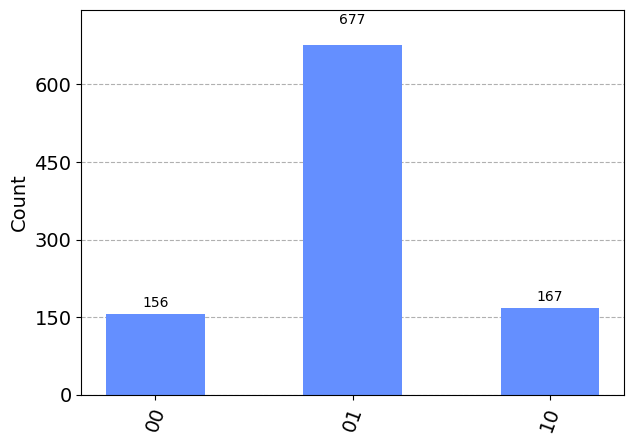

In [19]:
m_zx = QuantumCircuit(2,2)
m_zx.h(1)
m_zx.measure([0,1],[0,1])

qc_compiled = transpile(qc.compose(m_zx), backend)

print('Results for x and z measurement:')
counts = backend.run(qc_compiled, shots=1000).result().get_counts(qc_compiled)
plot_histogram(counts)

In both cases we never observe 11. What is our expectation now if both observers do an x measurement? In this case a measurement of 1 for both seems impossible. Why? From classical logic we would infer:

1. If z measurements are applied on both qubits, they can never both be 0.
2. If an x measurement on one qubit yields 1, a z measurement of the other must give 0.

If Alice does an x measurement and finds a 1, then from (2) she will conclude that Bob would have measured a 0 if he would have done a z measurement instead. Same for Bob, if he finds a 1 in an x measurement, he says that Alice would surely have got a 0 if she'd done a z measurement. But according to (1) this can never happen, the z measurements for the qubits can't output 0 for both.

Check:

Results for x measurements:


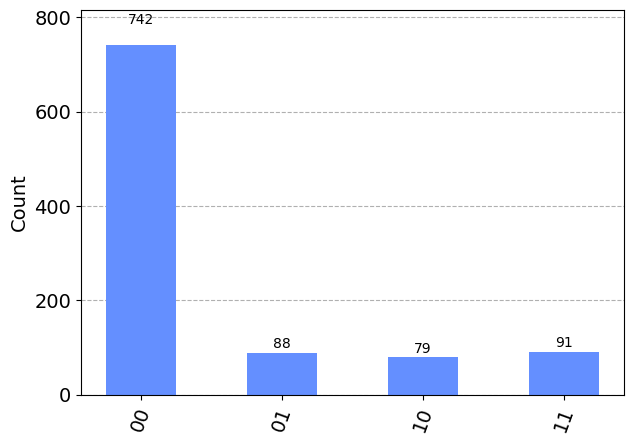

In [20]:
m_xx = QuantumCircuit(2,2)
m_xx.h(0)
m_xx.h(1)
m_xx.measure([0,1],[0,1])

qc_compiled = transpile(qc.compose(m_xx), backend)

print('Results for x measurements:')
counts = backend.run(qc_compiled, shots=1000).result().get_counts(qc_compiled)
plot_histogram(counts)

In fact we find the result 11 with the same probability as 01 and 10 which contradicts our logic.